In [258]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps
import seaborn as sns
from scipy import ndimage
from skimage.filters import threshold_minimum, threshold_otsu
import sys
#from skimage.morphology import skeletonize

#Allow Pillow to open very large images
Image.MAX_IMAGE_PIXELS = None

#Check if OpenCV is using optimised code
cv2.useOptimized()

True

In [223]:
# Import HEMnet package
BASE_DIR = Path().resolve().parent
HEMNET_DIR = BASE_DIR.joinpath('HEMnet')
sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *
from normaliser import IterativeNormaliser

In [247]:
ANNOTATIONS_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Annotated_Jpegs')
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/03_06_20_testing')
TEMPLATE_SLIDE_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/1957_T_9668_3_HandE.svs')

ALIGNMENT_MAG = 2
TILE_MAG = 10
#Allow user to select between 'none', 'reinhard', 'macenko' and 'vahadane'
NORMALISER_METHOD = "vahadane"
STANDARDISE_LUMINOSITY = True
VERBOSE = True

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

In [4]:
annotated_imgs = []
for img in ANNOTATIONS_PATH.glob('*.jpg'):
    name = img.name
    annotated_imgs.append(name)
annotated_imgs.sort()
annotated_imgs

['carlosjosesuarez_crcoutlines_170824_green_Page_01.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_02.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_03.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_04.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_05.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_06.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_07.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_08.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_09.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_10.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_11.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_12.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_13.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_14.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_15.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_16.jpg',
 'carlosjosesuarez_crcoutlines_170824_green_Page_17.jpg',
 'carlosjosesu

In [5]:
def imshow(img_bgr):
    """Display colour OpenCV image with Pillow
    
    Parameters
    ----------
    img_bgr : OpenCV(bgr) image
    
    Returns
    -------
    img : Pillow(rgb) image
    """
    img_rgb = img_bgr[:, :, ::-1]    #Convert from BGR to RGB
    return Image.fromarray(img_rgb)

def imshow_gray(img_gray):
    return Image.fromarray(img_gray, 'L')

In [199]:
annotated_img_path = ANNOTATIONS_PATH.joinpath(annotated_imgs[6])
annotated_img = cv2.imread(str(annotated_img_path))

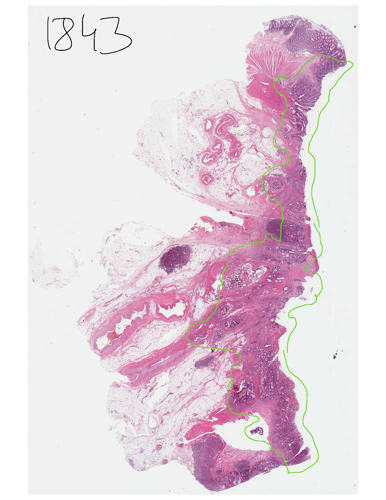

In [200]:
thumbnail(imshow(annotated_img), (500,500))

## Detect picture area

In [91]:
annotated_img_gray = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2GRAY)

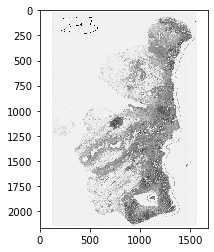

In [92]:
plt.imshow(annotated_img_gray, cmap = 'gray')

In [103]:
annotated_img_thresh = cv2.threshold(annotated_img_gray, 250, 255, cv2.THRESH_BINARY)[1]

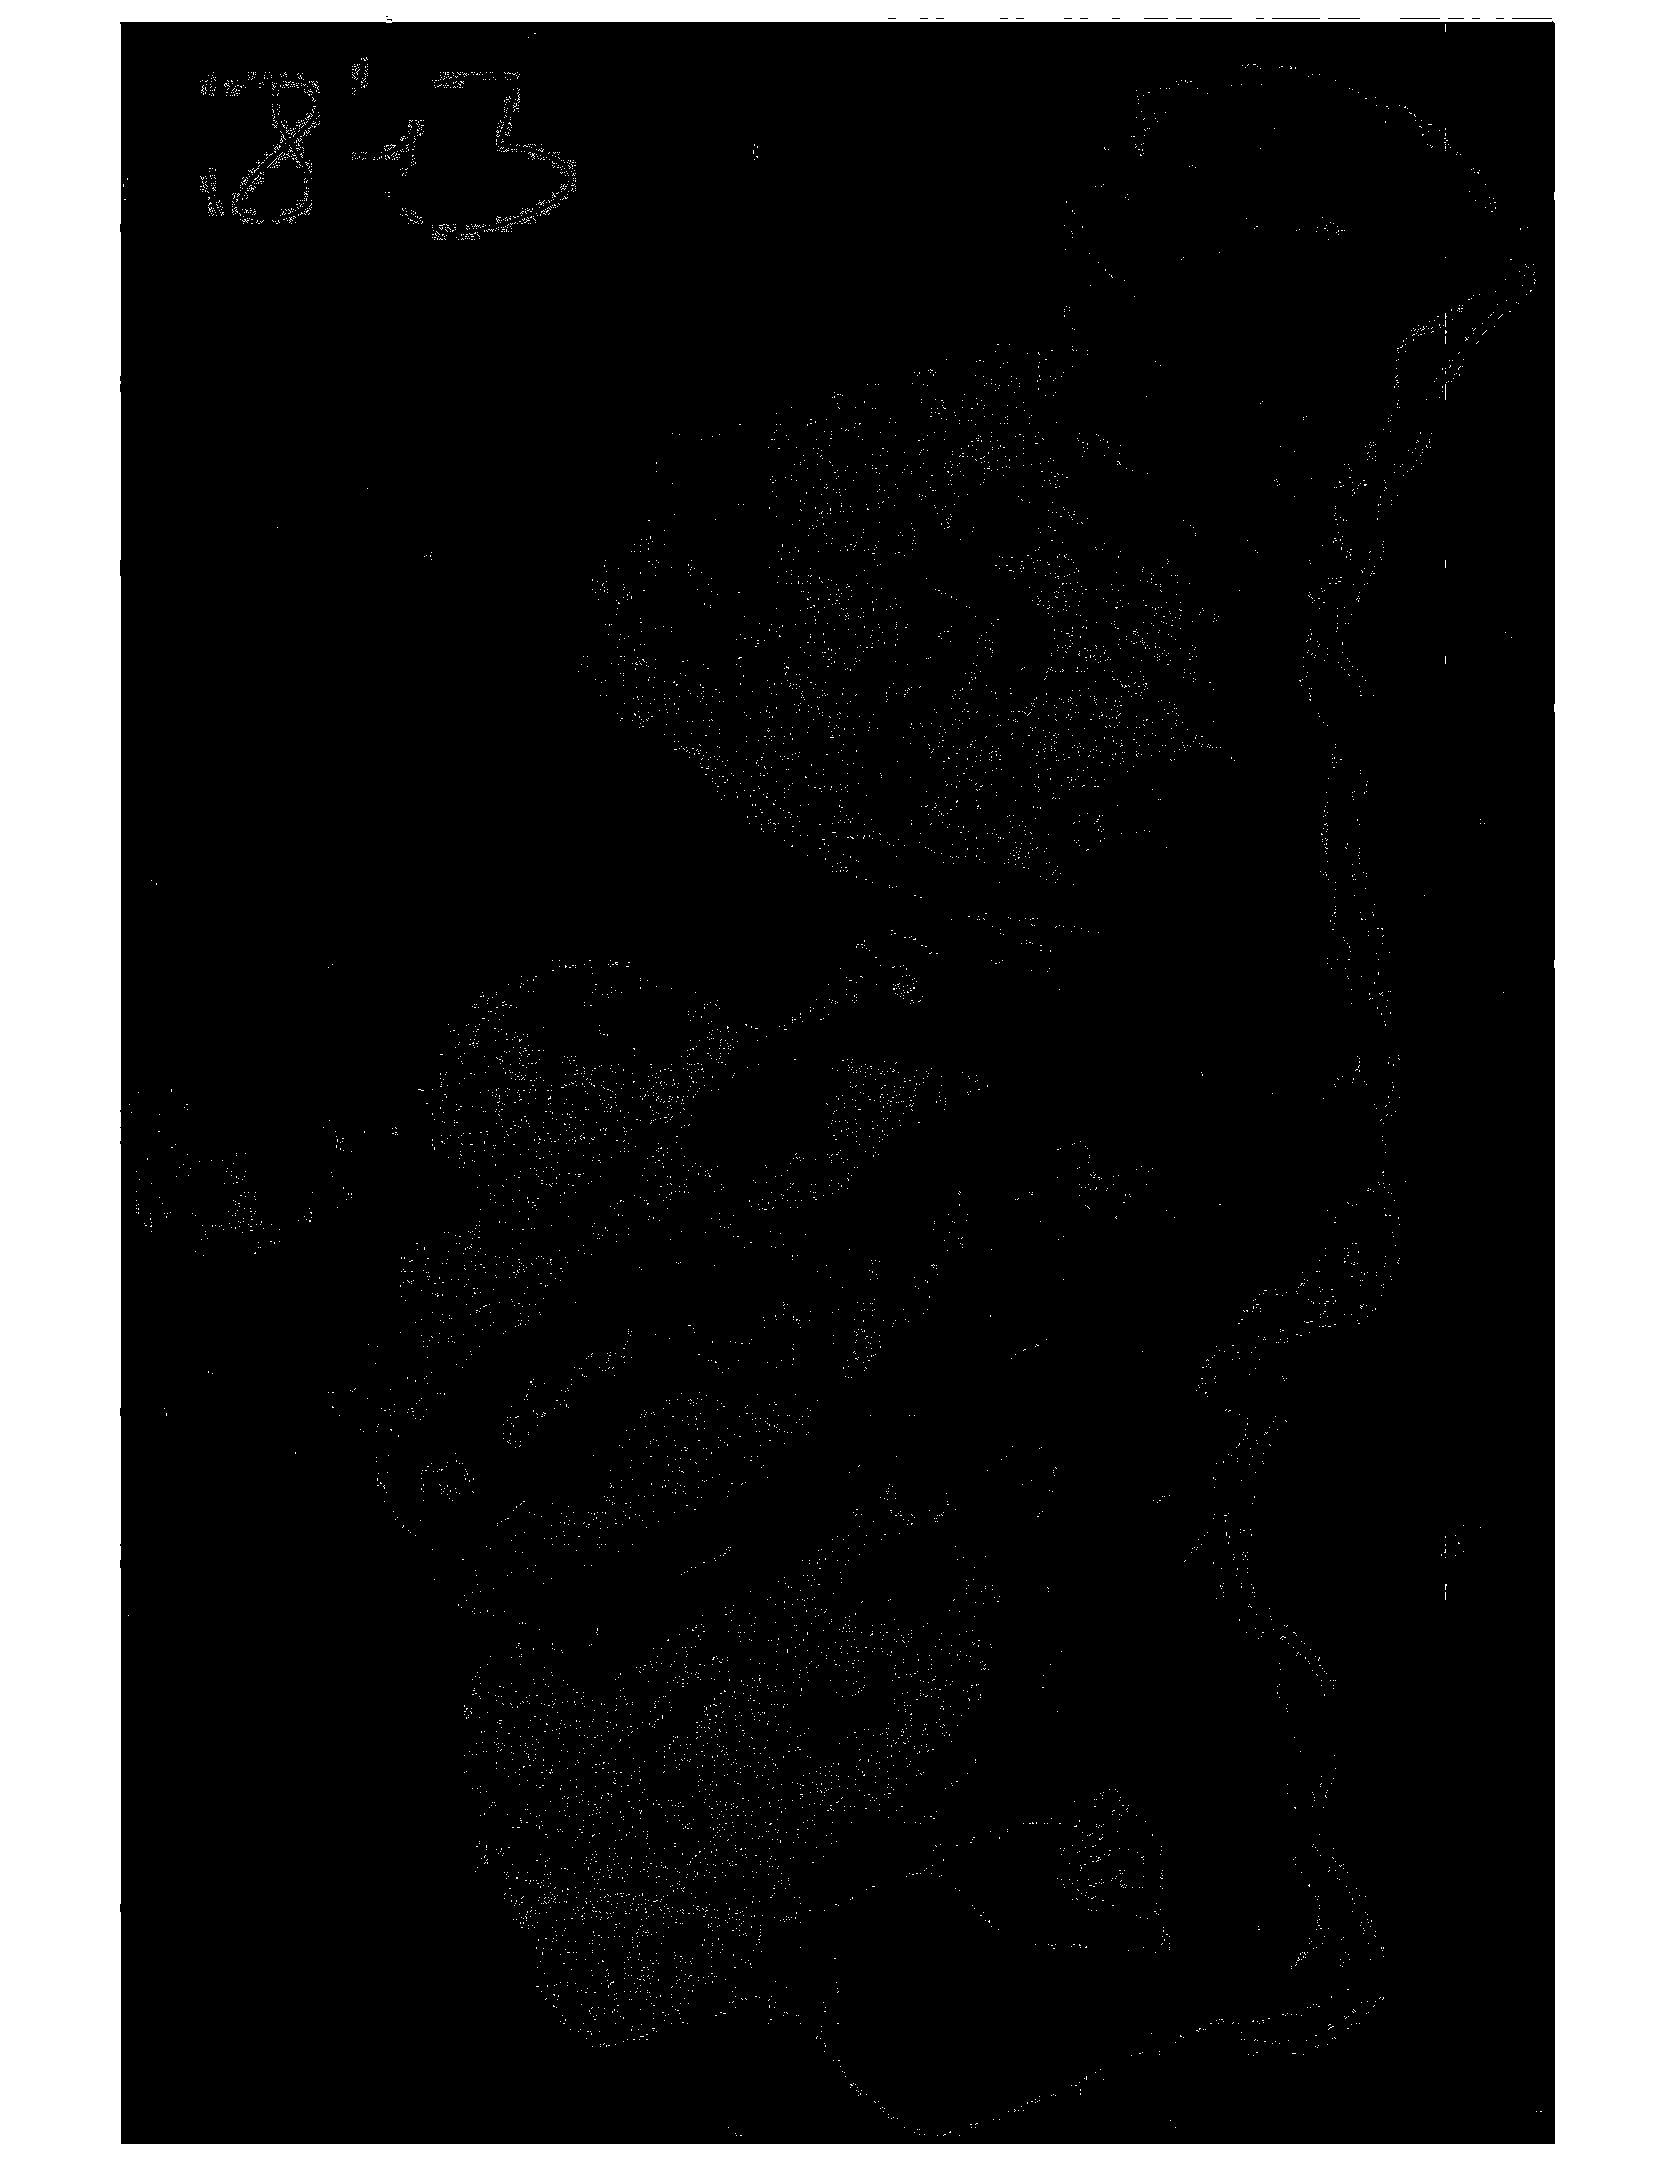

In [104]:
imshow_gray(annotated_img_thresh)

In [154]:
#Close image
kernal_5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
# closed = cv2.morphologyEx(annotated_img_thresh, cv2.MORPH_CLOSE, kernal_5)
# imshow_gray(closed)

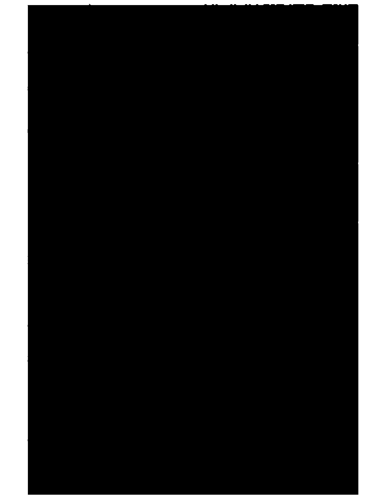

In [156]:
opened = cv2.morphologyEx(annotated_img_thresh, cv2.MORPH_OPEN, kernal_5)
thumbnail(imshow_gray(opened), (500,500))

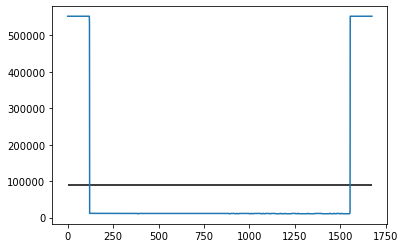

In [176]:
horizontal_px_sums = np.sum(opened, axis = 0).astype(np.int64)
plt.plot(horizontal_px_sums)
horizontal_threshold = np.mean(horizontal_px_sums)
plt.hlines(horizontal_threshold, 0, len(horizontal_px_sums))

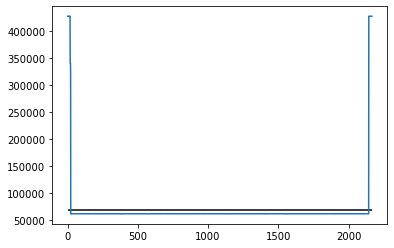

In [179]:
vertical_px_sums = np.sum(opened, axis = 1).astype(np.int64)
plt.plot(vertical_px_sums)
vertical_threshold = np.mean(vertical_px_sums)
plt.hlines(vertical_threshold, 0, len(vertical_px_sums))

In [187]:
img_rows = np.where(vertical_px_sums < vertical_threshold)
y_top = np.min(img_rows)
y_bottom = np.max(img_rows)

In [192]:
img_columns = np.where(horizontal_px_sums < horizontal_threshold)
x_left = np.min(img_columns)
x_right = np.max(img_columns)

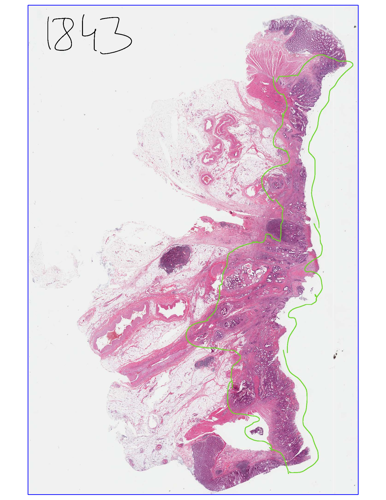

In [201]:
annotated_img_box = annotated_img.copy()
annotated_img_box = cv2.rectangle(annotated_img_box, (x_left, y_top), (x_right, y_bottom), (255,0,0), 2)
thumbnail(imshow(annotated_img_box), (500,500))

In [202]:
#Crop the annotated image to just the slide area
annotated_slide = annotated_img[y_top:y_bottom, x_left:x_right]

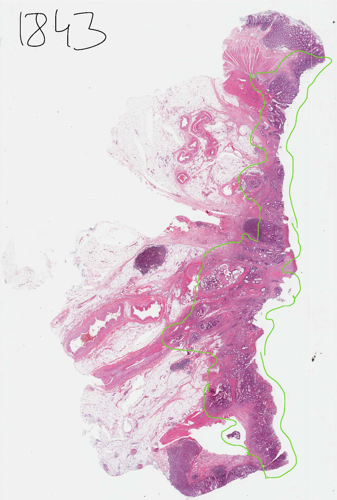

In [204]:
thumbnail(imshow(annotated_slide), (500,500))

In [ ]:
#detect corners
dst = cv2.cornerHarris(opened, 5, 7, 0.1)
dst = cv2.dilate(dst, None)
imshow_gray(dst)

In [ ]:
imshow_gray(dst>(0.01*dst.max()))

In [124]:
annotated_img_corners= annotated_img.copy
annotated_img_corners[dst>0.01*dst.max()]=[0,0,255]
imshow(annotated_img_corners)

TypeError: 'builtin_function_or_method' object does not support item assignment

## Detect Annotation Lines

In [205]:
# order of colours is bgr
lower_colour_bounds = (0, 160, 0)
upper_colour_bounds = (150, 255, 150)

annotation_mask = cv2.inRange(annotated_slide, lower_colour_bounds, upper_colour_bounds)

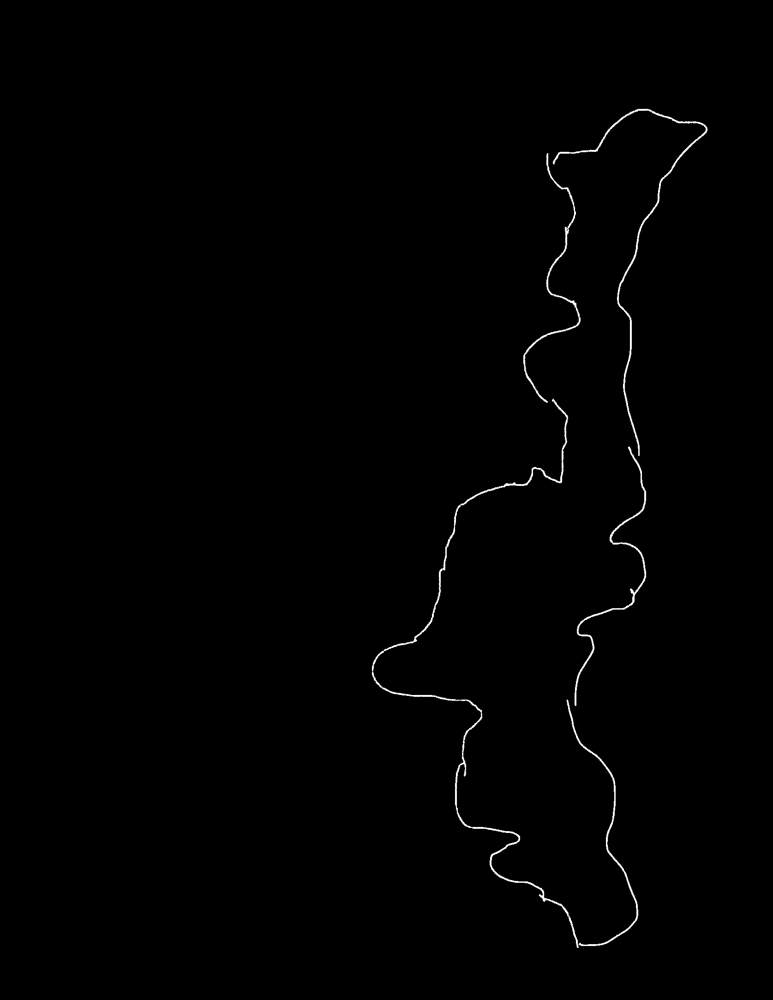

In [206]:
thumbnail(imshow_gray(mask))

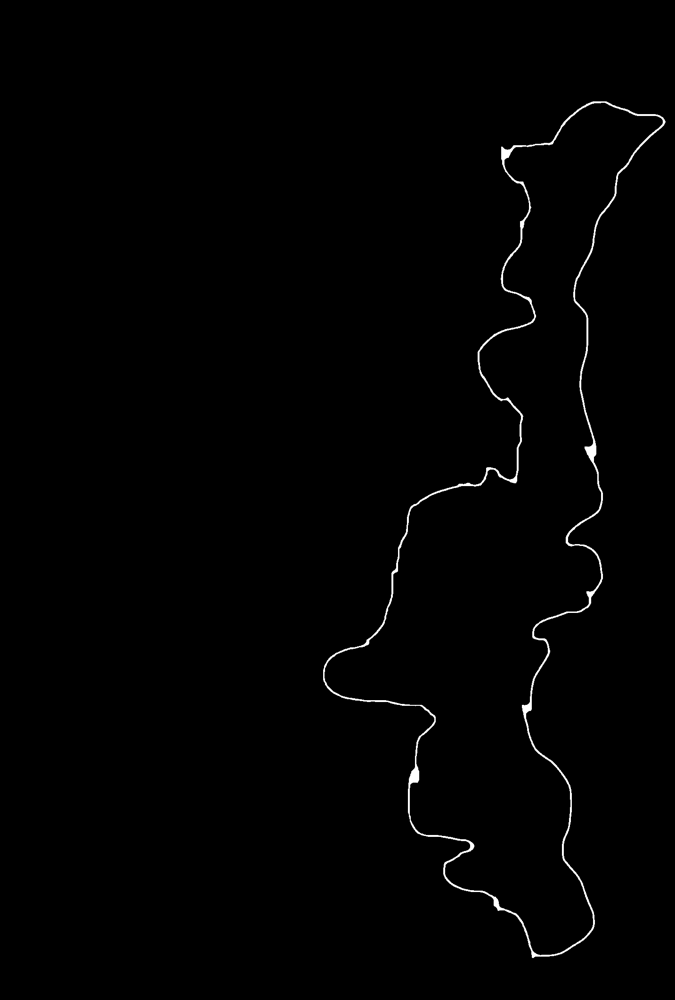

In [207]:
# Fill gaps in contour
kernal_20 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
annotation_mask_closed = cv2.morphologyEx(annotation_mask, cv2.MORPH_CLOSE, kernal_20)
thumbnail(imshow_gray(annotation_mask_closed))

In [208]:
# # Fill gaps in contour 
# kernal = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
# dilated = cv2.dilate(annotation_mask, kernal)
# eroded = cv2.erode(dilated, kernal)
# imshow_gray(eroded)

In [209]:
contours, hierachy = cv2.findContours(annotation_mask_closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [210]:
perimeters = [cv2.arcLength(cnt, True) for cnt in contours]
np.argmax(perimeters)

1

In [211]:
perimeters

[5528.388407945633, 5548.530547857285]

In [212]:
hierachy

array([[[-1, -1,  1, -1],
        [-1, -1, -1,  0]]], dtype=int32)

In [215]:
img = cv2.drawContours(annotated_slide.copy(), contours, 0, (255, 0, 0), 3)

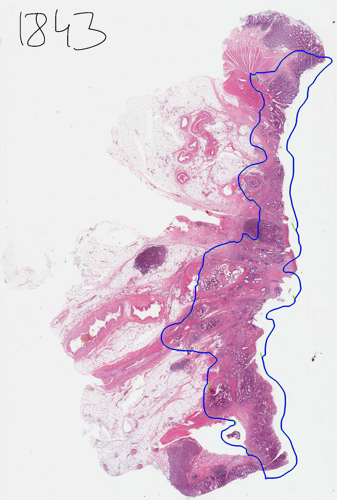

In [216]:
thumbnail(imshow(img), (500, 500))

In [217]:
hierachy

array([[[-1, -1,  1, -1],
        [-1, -1, -1,  0]]], dtype=int32)

To find contours that wrap around our annotations, we want to get the parent contours. <br>
The parent contours are found by selecting contours that have a child (i.e. the 3rd column of hierachy is not -1)

In [218]:
parent_cnts = np.where(hierachy[0][:,2]!= -1)[0]
parent_cnts

array([0])

In [219]:
cnt_mask = np.zeros(annotation_mask_closed.shape[0:2])
for i in parent_cnts:
    cnt = contours[i]
    cnt_mask = cv2.drawContours(cnt_mask, [cnt], 0, 255, -1)
cnt_mask = cnt_mask.astype(np.uint8)

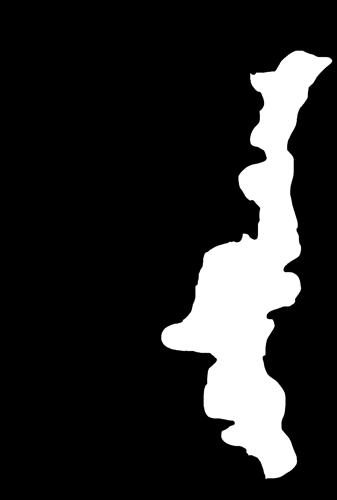

In [220]:
thumbnail(imshow_gray(cnt_mask), (500,500))

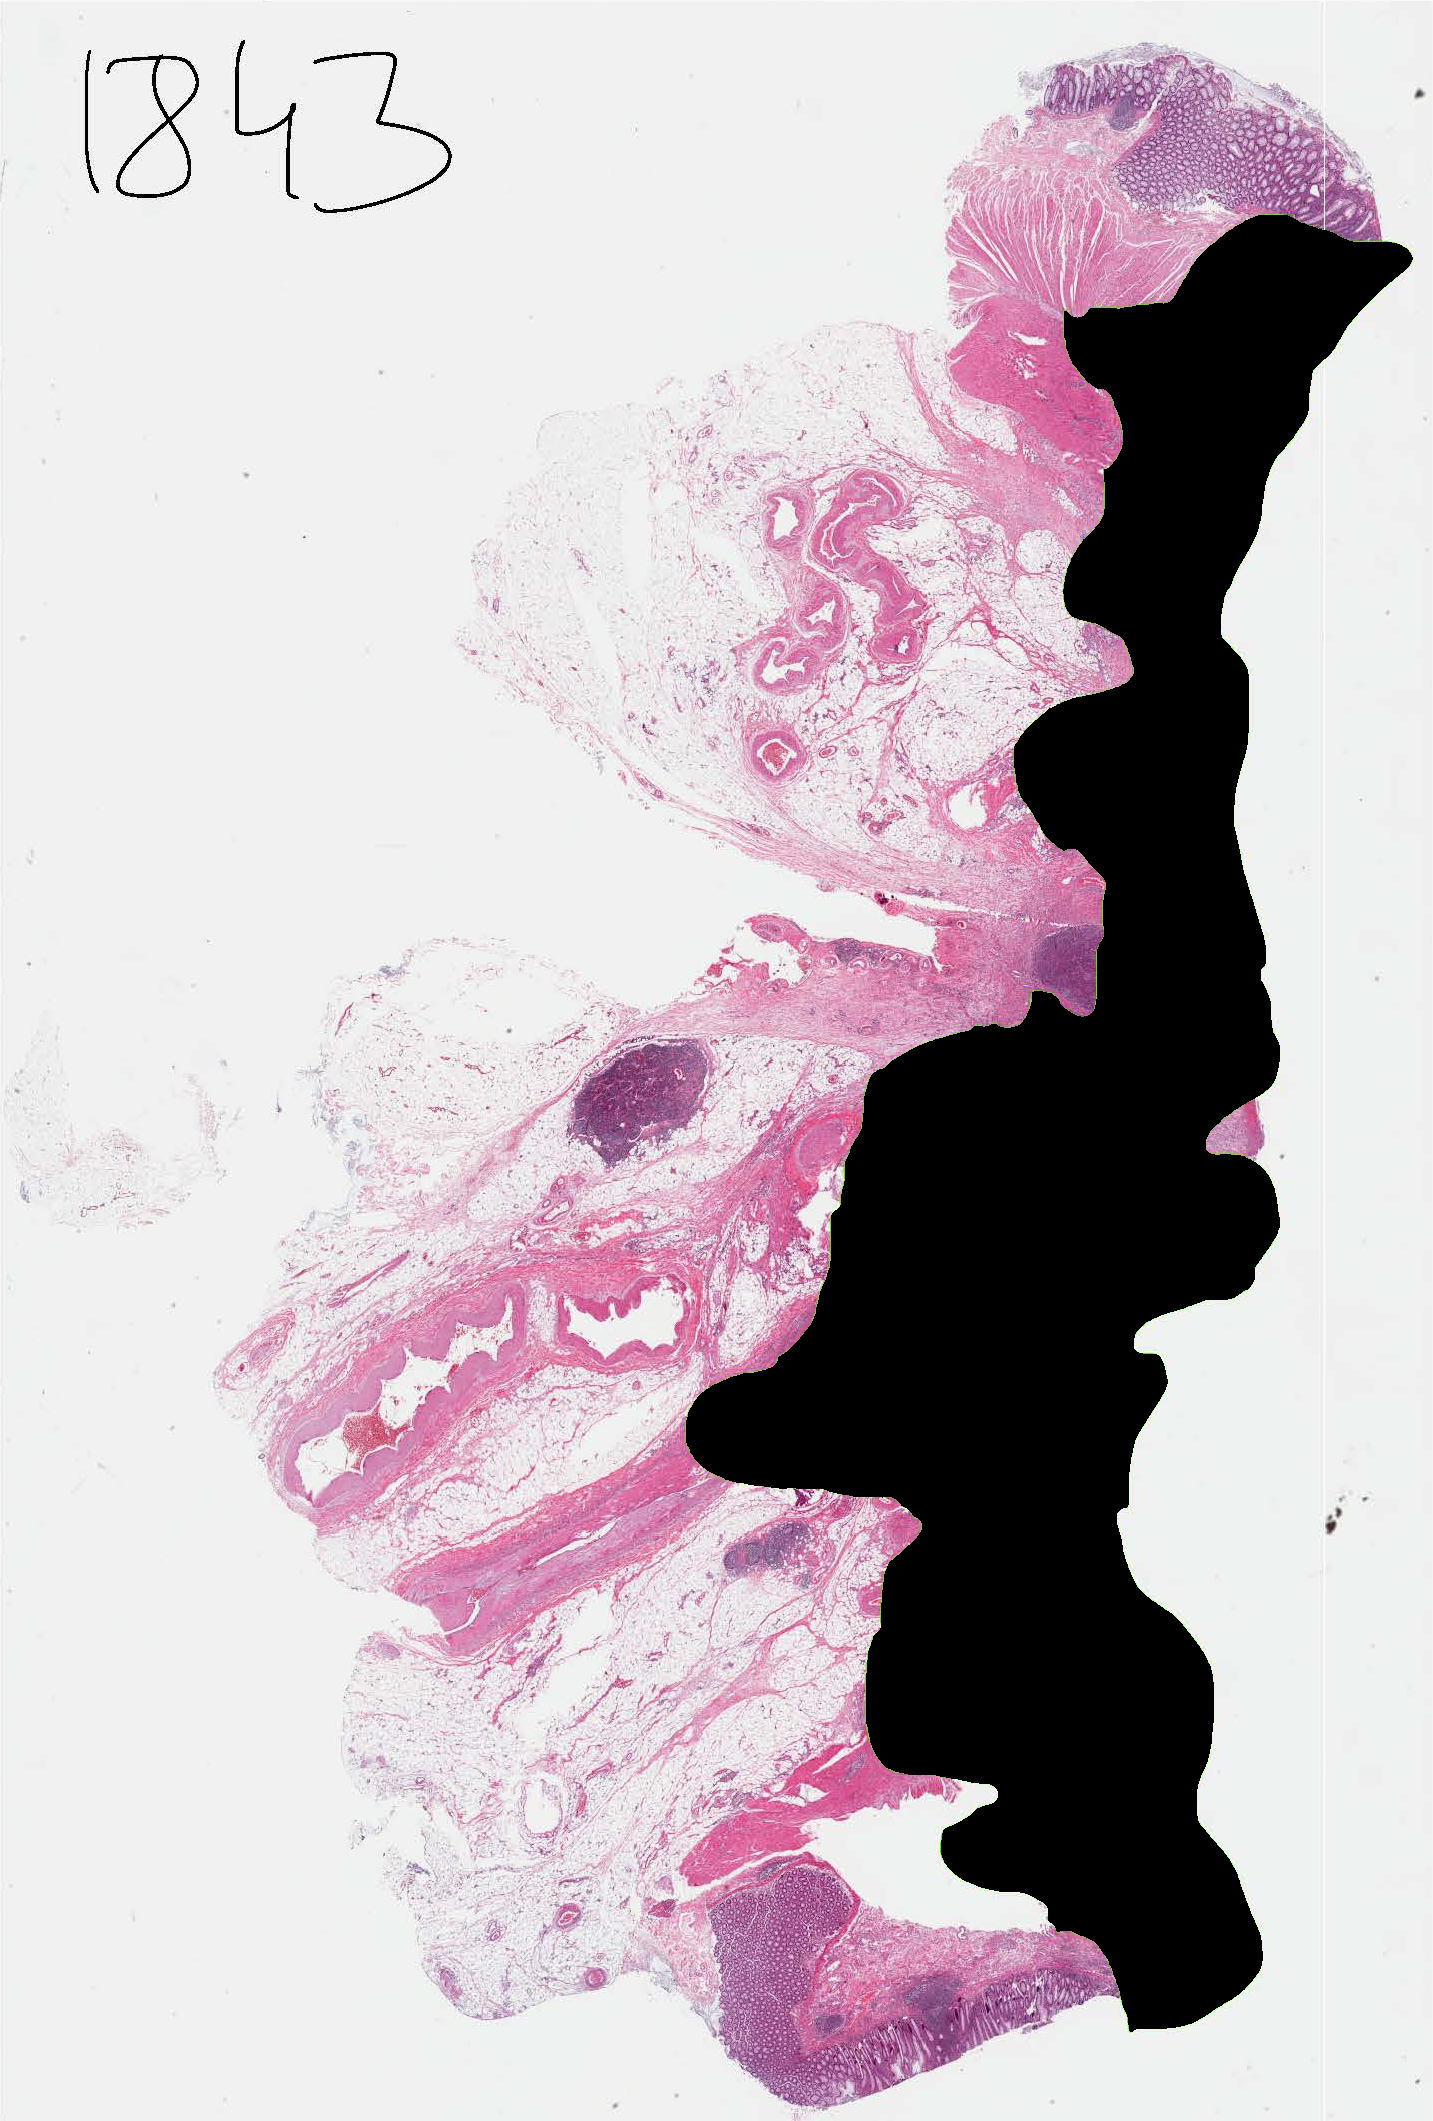

In [221]:
imshow(cv2.bitwise_and(annotated_slide, annotated_slide, mask = cv2.bitwise_not(cnt_mask)))

## Map to Slides

In [248]:
# Find Slides
slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
#slides
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
print('Found {0} pairs of slides'.format(len(Paired_slides)))
for i, pair in enumerate(Paired_slides):
    tp53, he = pair
    verbose_print('{0}. {1}|{2}'.format(i + 1, tp53, he))

Found 35 pairs of slides
1. 1792_T_9500_2_TP53.svs|1792_T_9500_3_HandE.svs
2. 1794_T_9504_2_TP53.svs|1794_T_9504_3_HandE.svs
3. 1798_T_9514_2_TP53.svs|1798_T_9514_3_HandE.svs
4. 1820_N_10545A_4_TP53.svs|1820_N_10545A_2_HandE.svs
5. 1820_T_105452F_4_TP53.svs|1820_T_105452F_2_HandE.svs
6. 1843_T_9561_2_TP53.svs|1843_T_9561_3_HandE.svs
7. 1879_T_9580_2_TP53.svs|1879_T_9580_3_HandE.svs
8. 1910_T_9637_2_TP53.svs|1910_T_9637_3_HandE.svs
9. 1915_T_10464_2_TP53.svs|1915_T_10464_3_HandE.svs
10. 1919_T_10779_2_TP53.svs|1919_T_10779_3_HandE.svs
11. 1928_T_9644_2_TP53.svs|1928_T_9644_3_HandE.svs
12. 1932_T_9876_2_TP53.svs|1932_T_9876_3_HandE.svs
13. 1939_T_9661_2_TP53.svs|1939_T_9661_3_HandE.svs
14. 1957_T_9668_2_TP53.svs|1957_T_9668_3_HandE.svs
15. 2011_T_9699_2_TP53.svs|2011_T_9699_3_HandE.svs
16. 2019_T_9717_2_TP53.svs|2019_T_9717_3_HandE.svs
17. 2023_T_9727_2_TP53.svs|2023_T_9727_3_HandE.svs
18. 2036_T_9729_2_TP53.svs|2036_T_9729_3_HandE.svs
19. 2038_T_11986_2_TP53.svs|2038_T_11986_3_HandE.svs

In [249]:
PREFIX_SHORT = '1843'
SLIDE_NUM = np.argmax([PREFIX_SHORT in slide_name for slide_name in HE_slides])
PREFIX = Paired_slides[SLIDE_NUM][0][:-8]
verbose_print('Processing Slide: {0}'.format(PREFIX))
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

Processing Slide: 1843_T_9561_2_


In [241]:
template_slide = open_slide(str(TEMPLATE_SLIDE_PATH))
template_img = read_slide_at_mag(template_slide, ALIGNMENT_MAG).convert('RGB')

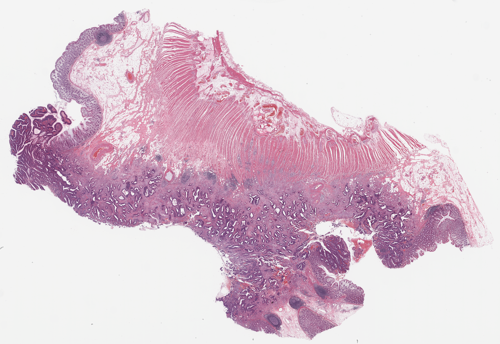

In [242]:
thumbnail(template_img, (500,500))

In [243]:
normaliser = IterativeNormaliser(NORMALISER_METHOD, STANDARDISE_LUMINOSITY)
normaliser.fit_target(template_img)

In [250]:
#Load Slides
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG)
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

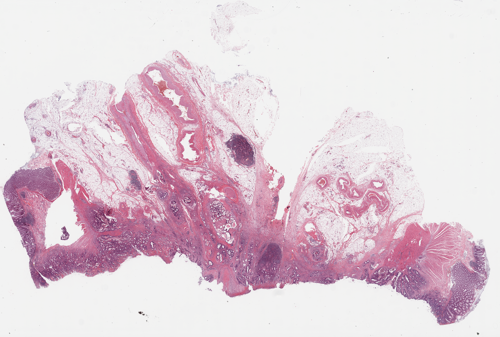

In [251]:
thumbnail(he, (500, 500))

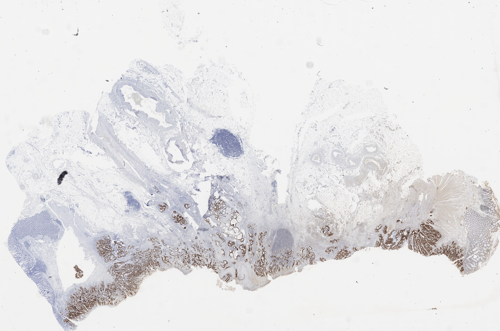

In [257]:
thumbnail(tp53, (500,500))

In [255]:
normaliser.fit_source(he)
he_norm = normaliser.transform_tile(he)

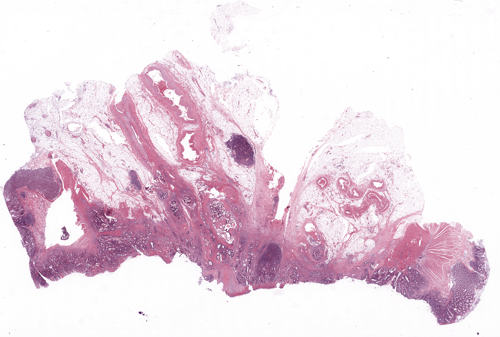

In [256]:
thumbnail(he_norm, (500,500))

In [287]:
ROTATION = -90
annotated_slide_rotated = ndimage.rotate(annotated_slide, ROTATION)

In [270]:
annotated_height, annotated_width = annotated_slide_rotated.shape[:2]
width, height = he_norm.size

In [271]:
width/annotated_width

3.1933050447901934

In [272]:
height/annotated_height

3.192602930914166

In [313]:
annotated_slide_resized = cv2.resize(annotated_slide_rotated, he_norm.size, cv2.INTER_CUBIC)

In [314]:
annotated_slide_rotated.shape

(1433, 2121, 3)

In [315]:
annotated_slide_resized.shape

(4575, 6773, 3)

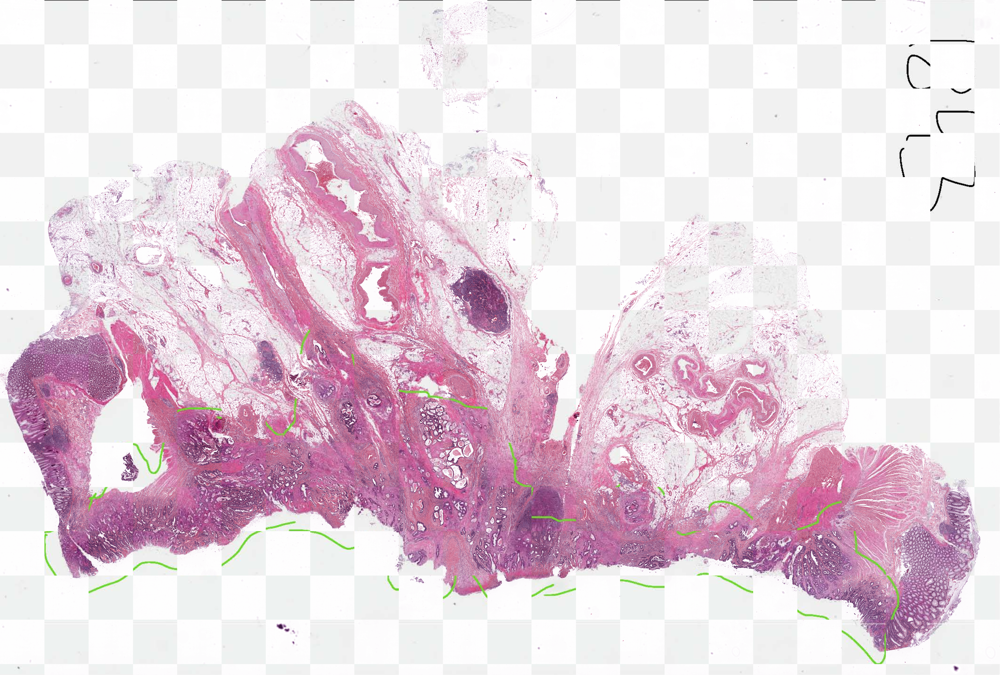

In [316]:
plotter = PlotImageAlignment('mosaic', 300)
overlay = plotter.plot_images(he_norm, imshow(annotated_slide_resized))
thumbnail(overlay)

In [311]:
#Rotate and scale contour mask
cnt_mask_rotated = ndimage.rotate(cnt_mask, ROTATION)
cnt_mask_resized = cv2.resize(cnt_mask_rotated, he_norm.size, cv2.INTER_CUBIC)

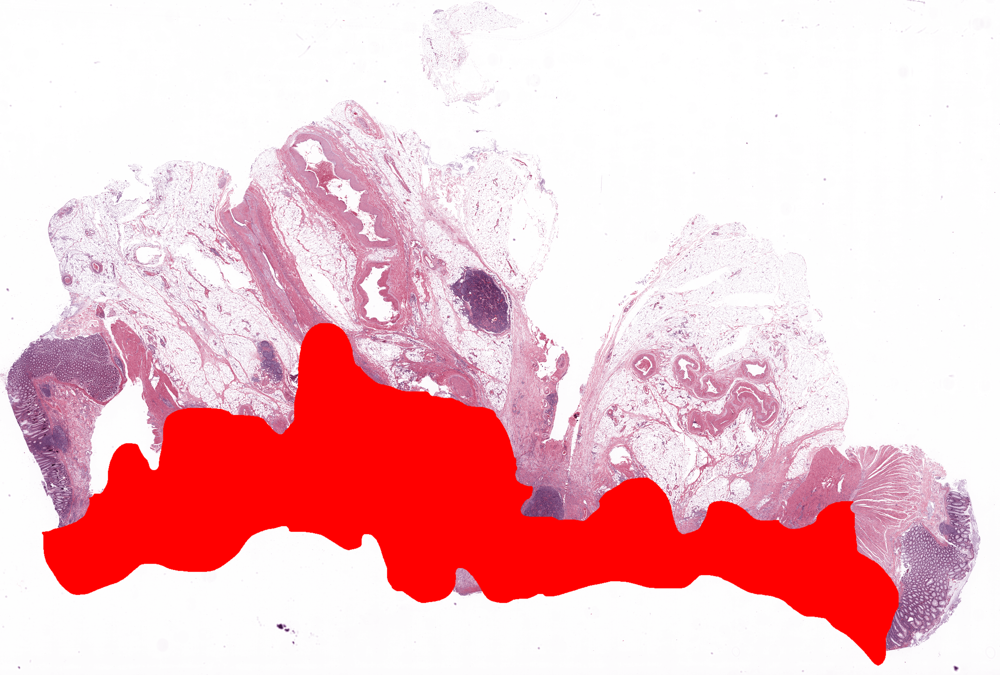

In [317]:
red_img = Image.new('RGB', (he_norm.size), (255, 0 ,0))
cnt_mask_pil = imshow_gray(cnt_mask_resized)
thumbnail(Image.composite(red_img, he_norm , cnt_mask_pil))

In [318]:
tile_size = 299*ALIGNMENT_MAG/TILE_MAG

In [326]:
tgen = tile_gen(cnt_mask_pil, tile_size)
c_mask = np.invert(threshold_mask(tgen, 128).astype(np.bool))

In [327]:
def show_mask(mask):
    mask = mask.astype(np.uint8)
    plt.imshow(np.reshape(mask, mask.shape[::-1]))
    plt.colorbar()

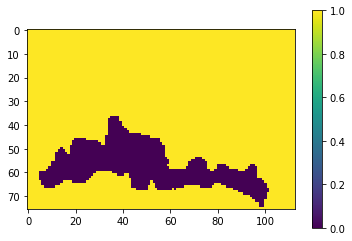

In [328]:
show_mask(c_mask)

In [355]:
#Remove background from H&E Image
he_filtered = filter_green(he_norm)
he_filtered = filter_grays(he_filtered, tolerance = 15)

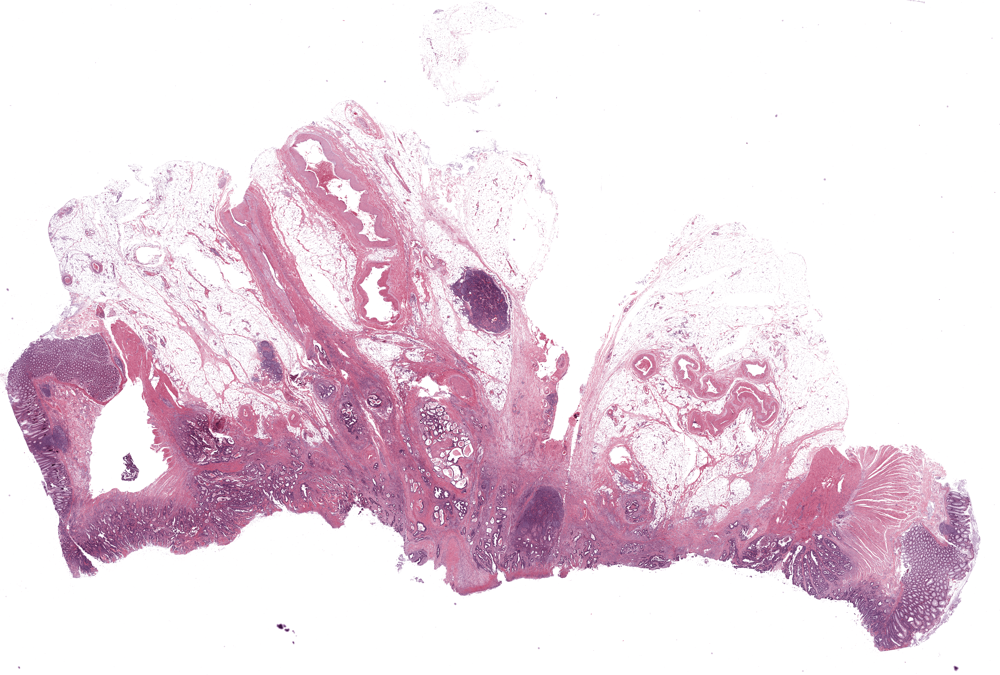

In [356]:
thumbnail(he_filtered)

In [357]:
t_mask_he = tissue_mask(he_filtered, tile_size, 0.01)

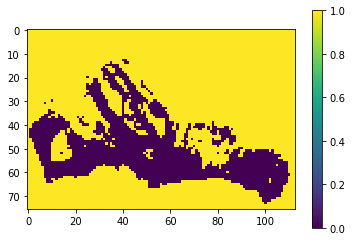

In [358]:
show_mask(t_mask_he)

In [361]:
#Make sure all cancer tiles exist in the tissue mask
c_mask_filtered = np.logical_not(np.logical_not(c_mask) & np.logical_not(t_mask_he))

In [364]:
overlay_he = plot_masks(he_filtered, c_mask_filtered, t_mask_he, tile_size)

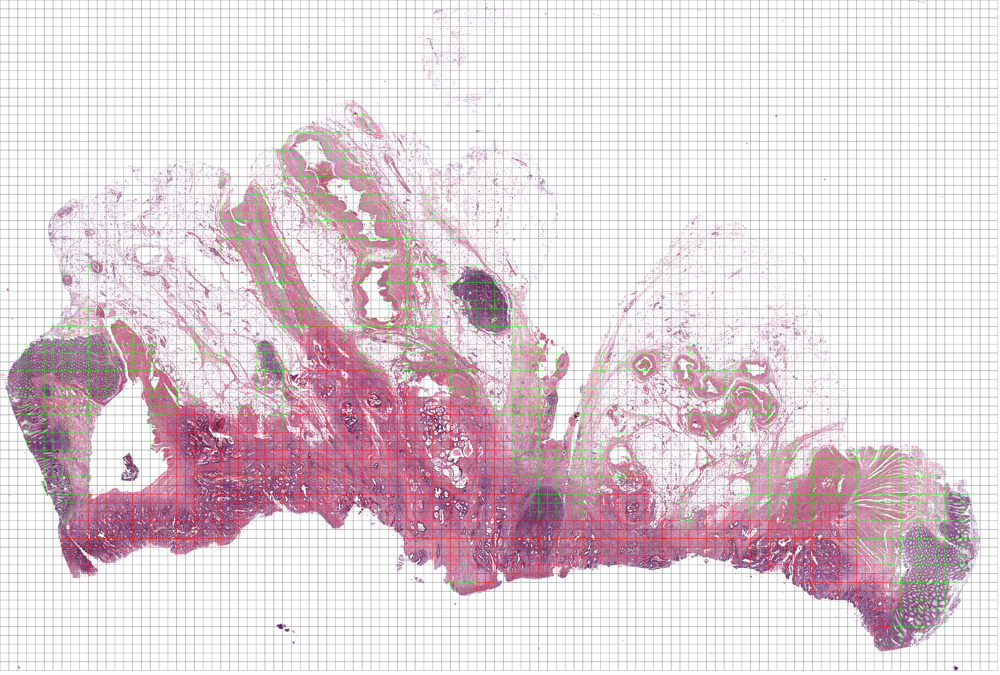

In [365]:
thumbnail(overlay_he)

In [366]:
##############
# Save Tiles #
##############

#Make Directory to save tiles
TILES_PATH = OUTPUT_PATH.joinpath('tiles_' + str(TILE_MAG) + 'x') 
os.makedirs(TILES_PATH, exist_ok = True)


In [368]:
def save_tiles(path, tile_gen, cancer_mask, tissue_mask, prefix = ''):
    os.makedirs(path.joinpath('cancer'), exist_ok = True)
    os.makedirs(path.joinpath('non-cancer'), exist_ok = True)
    x_tiles, y_tiles = next(tile_gen)
    verbose_print('Whole Image Size is {0} x {1}'.format(x_tiles, y_tiles))
    i = 0 
    for tile in tile_gen:
        img = tile.convert('RGB')
        ###
        img_norm = normaliser.transform_tile(img)
        ###
        #Name tile as horizontal position _ vertical position starting at (0,0)
        tile_name = prefix + str(np.floor_divide(i,x_tiles)) + '_' +  str(i%x_tiles) 
        if cancer_mask.ravel()[i] == 0:
            img_norm.save(path.joinpath('cancer', tile_name + '.jpeg'), 'JPEG')
        elif tissue_mask.ravel()[i] == 0:
            img_norm.save(path.joinpath('non-cancer', tile_name + '.jpeg'), 'JPEG')
        i += 1
    verbose_print('Exported tiles for {0}'.format(prefix))

In [370]:
tgen = tile_gen_at_mag(he_slide, TILE_MAG, 299)
save_tiles(TILES_PATH, tgen, c_mask_filtered, t_mask_he, prefix = PREFIX)

Whole Image Size is 113 x 76
Exported tiles for 1843_T_9561_2_
